In [ ]:
#!pip install transformers
!pip install accelerate -U
!pip install transformers[torch]
!pip install datasets
!pip install wandb
#!pip install huggingface_hub

In [ ]:
import pandas as pd
from google.colab import userdata
import torch
from torch.utils.data import Dataset
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import random
from torchvision.transforms import v2
from tqdm.notebook import tqdm
import shutil
from pathlib import Path
from datasets import load_dataset
from huggingface_hub import notebook_login
from tqdm.notebook import tqdm
import wandb

# CFG

In [ ]:
class CFG:
  IMG_PATH = '/content/drive/MyDrive/Colab Data/buscomiperro/images'
  LABEL_PATH = '/content/drive/MyDrive/Colab Data/buscomiperro/labels.csv'



  AUGMENTATION = True

  SEED = 1313


# Split

In [ ]:
labels = pd.read_csv(CFG.LABEL_PATH)
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10412,o6,No detectado
10413,o7,No detectado
10414,o8,No detectado
10415,o9,No detectado


In [ ]:
X = labels.id
y = labels.breed

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, shuffle = True, stratify = y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=13, shuffle = True, stratify = y_train)

In [ ]:
train_data = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
val_data = pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
test_data = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)

In [ ]:
# IMG con 4 canales :s
test_data = test_data[test_data.id!='ca6'].reset_index(drop = True)

In [ ]:
train_data.breed.value_counts()

scottish_deerhound      91
maltese_dog             84
afghan_hound            84
entlebucher             83
bernese_mountain_dog    82
                        ..
golden_retriever        49
komondor                49
brabancon_griffon       49
eskimo_dog              48
briard                  48
Name: breed, Length: 122, dtype: int64

In [ ]:
val_data.breed.value_counts()

scottish_deerhound    10
cairn                  9
shih-tzu               9
tibetan_terrier        9
basenji                9
                      ..
brabancon_griffon      5
tibetan_mastiff        5
golden_retriever       5
briard                 5
komondor               5
Name: breed, Length: 122, dtype: int64

In [ ]:
test_data.breed.value_counts()

scottish_deerhound      25
maltese_dog             24
bernese_mountain_dog    23
entlebucher             23
shih-tzu                23
                        ..
eskimo_dog              13
brabancon_griffon       13
briard                  13
komondor                13
golden_retriever        13
Name: breed, Length: 122, dtype: int64

In [ ]:
len(test_data)

2083

# Create Dataset to Huggingface

We need something like this


```
my_dataset_repository/
├── README.md
├── train/classes/imgs
└── test/classes/imgs
```



In [ ]:
DatasetDir = Path("PetClassification")

In [ ]:
# 1. make Dataset Dir
os.mkdir(DatasetDir)
os.mkdir(DatasetDir/"train")
os.mkdir(DatasetDir/"validation")
os.mkdir(DatasetDir/"test")

In [ ]:
# 2. make classes dir
for breed in tqdm(train_data.breed.unique()):
  os.mkdir(DatasetDir/"train"/breed)
  os.mkdir(DatasetDir/"validation"/breed)
  os.mkdir(DatasetDir/"test"/breed)

  0%|          | 0/122 [00:00<?, ?it/s]

In [ ]:
def make_split_folder(split_df, split):
  # iterate over dataset
  for idx, row in tqdm(split_df.iterrows(), total = len(split_df), desc = f"Making {split} folder"):
    img_name, breed = row
    # copy files
    shutil.copyfile(f"{os.path.join(CFG.IMG_PATH, img_name)}.jpg", f"{DatasetDir/split/breed/img_name}.jpg")



In [ ]:
make_split_folder(train_data, "train")
make_split_folder(val_data, "validation")
make_split_folder(test_data, "test")

Making train folder:   0%|          | 0/7499 [00:00<?, ?it/s]

Making validation folder:   0%|          | 0/834 [00:00<?, ?it/s]

Making test folder:   0%|          | 0/2083 [00:00<?, ?it/s]

In [ ]:
pet_dataset = load_dataset("imagefolder", data_dir = "PetClassification")

Resolving data files:   0%|          | 0/7499 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/834 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2083 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
pet_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7499
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 834
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2083
    })
})

In [ ]:
# Push to Hub
notebook_login()

In [ ]:
pet_dataset.push_to_hub("Diegulio/PetClassification")

Map:   0%|          | 0/7499 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/75 [00:00<?, ?ba/s]

Map:   0%|          | 0/834 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Map:   0%|          | 0/2083 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

# Load Dataset from Huggingface

In [ ]:
pet_dataset = load_dataset("Diegulio/PetClassification")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7499 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/834 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2083 [00:00<?, ? examples/s]

In [ ]:
pet_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7499
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 834
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2083
    })
})

In [ ]:
labels = pet_dataset["train"].features["label"].names

idx2label = {idx: label for idx, label in enumerate(labels)}
label2idx = {label: idx for idx, label in enumerate(labels)}

In [ ]:
CFG.labels = labels
CFG.idx2label = idx2label
CFG.label2idx= label2idx

In [ ]:
pet_dataset = pet_dataset.shuffle(seed=CFG.SEED)

Breed: whippet


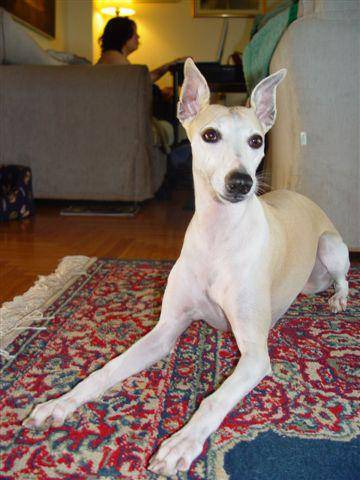

In [ ]:
random_idx = random.randint(0,len(pet_dataset['train']))
print(f"Breed: {CFG.idx2label[pet_dataset['train'][random_idx]['label']]}")
pet_dataset['train'][random_idx]['image']

# Processor
Aplicar map con processor, analizar el agregarle .convert(RGB)

In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Augmentation

In [ ]:
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = v2.Normalize(mean=image_mean, std=image_std)

In [ ]:
if CFG.AUGMENTATION:
  train_transform = v2.Compose([
      v2.Resize((processor.size["height"], processor.size["width"])),
      v2.RandomHorizontalFlip(0.4),
      v2.RandomVerticalFlip(0.1),
      v2.RandomApply(transforms=[v2.RandomRotation(degrees=(0, 90))], p=0.5),
      v2.RandomApply(transforms=[v2.ColorJitter(brightness=.3, hue=.1)], p=0.3),
      v2.RandomApply(transforms=[v2.GaussianBlur(kernel_size=(5, 9))], p=0.3),
      v2.ToTensor(),
      normalize
      #transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
  ])
else:
  train_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.ToTensor(),
    normalize
])

test_transform = v2.Compose([
    v2.Resize((processor.size["height"], processor.size["width"])),
    v2.ToTensor(),
    normalize
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
def train_transforms(examples):
    examples['pixel_values'] = [train_transform(image.convert("RGB")) for image in examples['image']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [test_transform(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# Set the transforms
pet_dataset['train'].set_transform(train_transforms)
pet_dataset['validation'].set_transform(test_transforms)
pet_dataset['test'].set_transform(test_transforms)

In [ ]:
pet_dataset['train'][0]['pixel_values']

tensor([[[-0.7176, -0.7176, -0.7255,  ...,  0.2078,  0.1843,  0.1686],
         [-0.7020, -0.7098, -0.7176,  ...,  0.1843,  0.1765,  0.1686],
         [-0.6863, -0.7020, -0.7176,  ...,  0.1608,  0.1529,  0.1451],
         ...,
         [-0.5216, -0.4196, -0.2941,  ...,  0.9373,  0.7882,  0.4039],
         [-0.5294, -0.3961, -0.2471,  ...,  0.8980,  0.6078,  0.1529],
         [-0.5686, -0.5059, -0.3569,  ...,  0.8275,  0.4588, -0.0275]],

        [[-0.6392, -0.6314, -0.6235,  ...,  0.2471,  0.2392,  0.2314],
         [-0.6000, -0.6235, -0.6314,  ...,  0.2235,  0.2157,  0.2078],
         [-0.6000, -0.6314, -0.6078,  ...,  0.1922,  0.1843,  0.1765],
         ...,
         [-0.3804, -0.3647, -0.2941,  ...,  0.4196,  0.1686, -0.2549],
         [-0.4118, -0.3412, -0.2392,  ...,  0.2863, -0.0902, -0.4902],
         [-0.4667, -0.4196, -0.3176,  ...,  0.1843, -0.2549, -0.6078]],

        [[-0.5608, -0.5843, -0.5922,  ...,  0.2549,  0.2627,  0.2549],
         [-0.5608, -0.5686, -0.5686,  ...,  0

# Collate Function

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


# Model

In [ ]:
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224',
                                                  id2label=CFG.idx2label,
                                                  label2id=CFG.label2idx,
                                                  ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([122]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([122, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

# Trainer

In [ ]:
#!pip install accelerate>=0.20.1
#!pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"breed-classification",
    #report_to = 'wandb',
    #run_name = "hf_ViT",
    use_cpu = False,
    #save_strategy="epoch",
    evaluation_strategy="steps",
    logging_steps = 100,
    #fp16 = True,
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [ ]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=pet_dataset['train'],
    eval_dataset=pet_dataset['validation'],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
100,4.289500,3.619047,0.449640
200,2.942000,2.502250,0.732614
300,1.886700,1.728931,0.796163
400,1.182400,1.267656,0.824940
500,0.737800,0.998546,0.845324
600,0.467300,0.849781,0.856115
700,0.290700,0.759574,0.845324
800,0.187700,0.707015,0.847722
900,0.125500,0.675780,0.850120
1000,0.090300,0.659821,0.854916


TrainOutput(global_step=1770, training_loss=0.7080926481613331, metrics={'train_runtime': 4904.4243, 'train_samples_per_second': 22.935, 'train_steps_per_second': 0.361, 'total_flos': 8.726061440224236e+18, 'train_loss': 0.7080926481613331, 'epoch': 15.0})

In [ ]:
outputs = trainer.predict(pet_dataset['test'])

In [ ]:
print(outputs.metrics)

{'test_loss': 0.6484691500663757, 'test_accuracy': 0.8497359577532405, 'test_runtime': 47.959, 'test_samples_per_second': 43.433, 'test_steps_per_second': 0.688}
